In [ ]:
%matplotlib inline

import autofit as af
from autolens.data import ccd
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.data.plotters import ccd_plotters
from autolens.lens.plotters import lens_fit_plotters
from autolens.model.galaxy import galaxy_model as gm
from autolens.pipeline.phase import phase_imaging


So, we want to fit an image with a lens model - and we want the combination of light profiles and mass profiles which fit the data well. How do we go about doing this?

To begin, we have to choose the parametrization of our lens model. We don't need to specify the values of its light and mass profiles (e.g. the centre, einstein_radius, etc.) - only the profiles themselves. In this example, we'll use the following lens model:

1) An Elliptical Isothermal Profile (SIE) for the lens galaxy's mass.
2) An External Shear, which accounts for lensing by line-of-sight galaxies near the lens.
3) An Elliptical Sersic light profile for the source galaxy's light.

I'll let you into a secret - this is the same lens model I used to simulate the image we're going to fit.

So, how do we infer the light and mass profile parameters that give a good fit to our data?

Well, we could randomly guess a lens model, corresponding to some random set of parameters. We could use this lens model to create a tracer and fit the image-data, and quantify how good the fit was using its likelihood. If we keep guessing lens models, eventually we'd find one that provides a good fit (i.e. high likelihood) to the data!

It may sound surprising, but this is actually the basis of how lens modeling works. However, we can do a lot better than random guessing. Instead, we track the likelihood of our previous guesses, and guess more models using combinations of parameters that gave higher likelihood solutions previously. The idea is that if a set of parameters provided a good fit to the data, another set with similar values probably will too.

This is called a 'non-linear search' and its a fairly common problem faced by scientists. In the howtolens lectures, we go fully into the details of how a non-linear search works. For the quick-start tutorial, we'll keep things much simpler.

We're going to use a non-linear search called 'MultiNest'. I highly recommend it, and find its great for lens modeling. However, lets not worry about the details of how MultiNest actually works. Instead, just picture that a non-linear search in PyAutoLens operates as follows:

1) Randomly guess a lens model and use its light-profiles and mass-profiles to set up a lens galaxy, source galaxy and a tracer.

2) Pass this tracer through the fitting module, generating a model image and comparing this model image to the observed strong lens imaging data. This computes a likelihood.

3) Repeat this many times, using the likelihoods of previous fits (typically those with a high likelihood) to guide us to the lens models with the highest liikelihood.

Firstly, we need to load the CCD data we're going to it, so you'll again need to change the path below to that of your workspace.

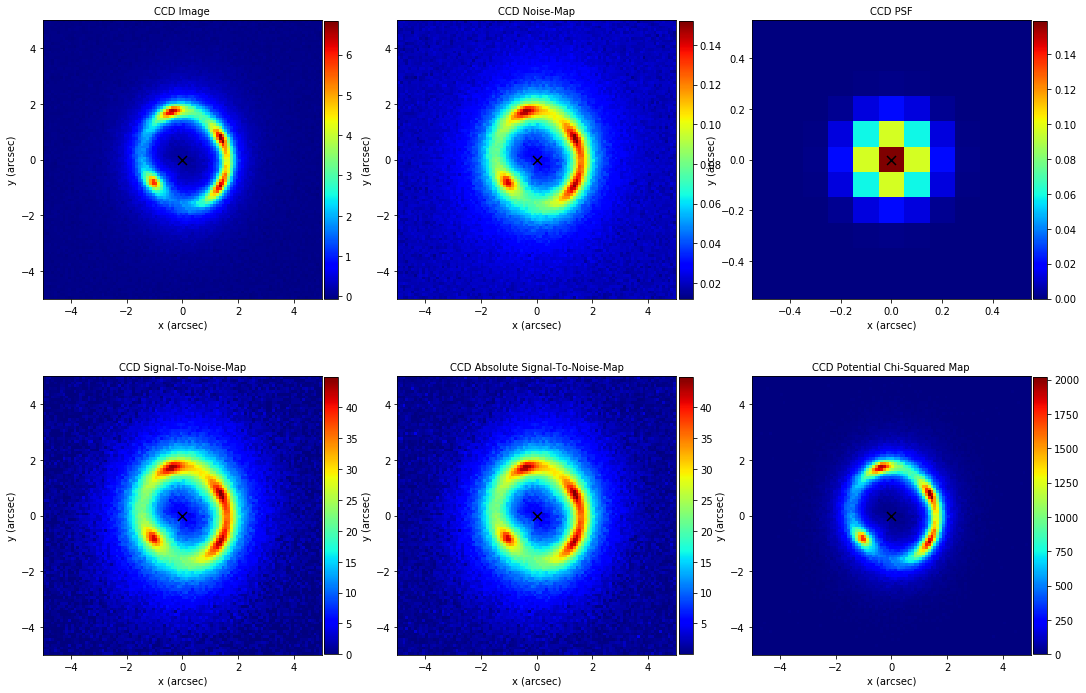

In [ ]:
workspace_path = "/path/to/user/autolens_workspace/"
workspace_path = "/home/jammy/PycharmProjects/PyAutoLens/workspace/"

data_path = workspace_path + "data/example/lens_mass_and_x1_source/"

ccd_data = ccd.load_ccd_data_from_fits(
    image_path=data_path + "image.fits",
    noise_map_path=data_path + "noise_map.fits",
    psf_path=data_path + "psf.fits",
    pixel_scale=0.1,
)

ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

This sets up the config files used by this tutorial, and the path where the output of the modeling is placed.

In [ ]:
af.conf.instance = af.conf.Config(
    config_path=workspace_path + "config", output_path=workspace_path + "output"
)

To set up a non-linear search, we use a GalaxyModel, which behaves analogously to the Galaxy objects we've seen before. However, whereas with a Galaxy we manually specified the value of every parameter of its light-profiles and mass-profiles, for a GalaxyModel these are inferred by the non-linear search.

Lets model the lens galaxy with an SIE mass profile and External Shear (which is what it was simulated with).

In [ ]:
lens_galaxy_model = gm.GalaxyModel(
    redshift=0.5, mass=mp.EllipticalIsothermal, shear=mp.ExternalShear
)

Lets model the source galaxy with an Elliptical Sersic light profile (again, what it was simulated with).

In [ ]:
source_galaxy_model = gm.GalaxyModel(redshift=1.0, light=lp.EllipticalSersic)

A phase takes our galaxy models and fits their parameters via a non-linear search (in this case, MultiNest). In this example, we have a lens-plane and source-plane, so we use a LensSourcePlanePhase.

(ignore the 'dict' - its necessary syntax but not something you need to concern yourself with)

In [ ]:
phase = phase_imaging.LensSourcePlanePhase(
    phase_name="quick_start_non_linear_search",
    galaxies=dict(lens_galaxy=lens_galaxy_model),
    galaxies=dict(source_galaxy=source_galaxy_model),
    optimizer_class=af.MultiNest,
)

Below, we manually set some of the MultiNest settings to speed up the lens modeling process. For now, I'd just ignore these, but note that it could be worth checking out the 'multinest_black_magic' tutorial in chapter 2 of the howtolens series to see what these are *actually* doing.

In [ ]:
phase.optimizer.const_efficiency_mode = True
phase.optimizer.n_live_points = 50
phase.optimizer.sampling_efficiency = 0.5

To run the phase, we simply pass it the image data we want to fit, and the non-linear search begins! As the phase runs, a logger will show you the parameters of the best-fit model.

Depending on the complexity of the model being fitted (e.g. the number of parameters) and resolution of the data, a non-linear search can take a while to run. Maybe minutes, maybe hours, maybe days! The image below should only take 10 minutes or so. Whilst you wait, lets explore the workspace a bit:

1) First, checkout the autolens_workspace/output/ folder, where you should see a folder 'quick_start_non_linear_search'. Here, our MultiNest output is stored, alongside images displaying the best-fit lens model. This visualization is output on-the-fly by PyAutoLens, which means you can watch the best-fit lens model improve as MultiNest runs in real time!

2) Next, lets look at the autolens_workspace/config. Here, you'll find config files that controls general PyAutoLens settings, what PyAutoLens visualizes, the default MultiNest settings and the priors we associated to the different parameters of different light and mass profiles.

3) The next folder is autolens_workspace/data. Not much to say here - before you begin modeling your own lenses, you put their data here (e.g. .fits files of the image, noise-map and PSF).

4) Finally, checkout the autolens_workspace/tools folder. This contains some Python scripts for doing standard tasks in PyAutoLens, such as simuating strong lens imaging, drawing custom masks for lens modeling and marking the brightest lensed source pixels in an image.

In [ ]:
print(
    "MultiNest has begun running"
    "This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!"
)

results = phase.run(data=ccd_data)

print("MultiNest has finished run - you may now continue the notebook.")

The best-fit solution (i.e. the highest likelihood) is stored in the 'results', which we can plot as per usual.

In [ ]:
lens_fit_plotters.plot_fit_subplot(fit=results.most_likely_fit)

NameError: name 'results' is not defined

And with that you've modeled your first lens with PyAutoLens! For the quick-start tutorial, that is the extent to which we're going to describe how lens modeling works in PyAutoLens. From here, we're simply going to use template pipelines to fit lenses with the mdoels you want. I'll emphasise again, the howtolens lecture series has 8 tutorials covering lens modeling in somewhat excrutiating detail - I heartily recommend you give it a look at some point in the future if you find yourself using PyAutoLens a lot!